# Analysis of the Correlations Within One Subject 

- Initially: Set the sub_id and saliency model  
- Path Directions - NSD dataset or data directory.
- Sort the ROIs in the plot from early vision areas to higher vision areas 
- Load the necessary data and indicate the paths 
- Print the *p* values for the corrleation values of a subject (modeld beta maps to ground truth beta data)
- Apply Fisher's Z transformation before calculating the mean
- Calculate mean r using Fisher's z transformation and perform a one-sample t-test
- Plot the *r*-values for the significant rho values of df_roi_stats *(without FDR correction)
- Plot the ROI-specific correlation over all ROIs (with significance stars for significant ROIs)
- Apply FDR correction to *p*-values
- Comparison of the original p-values with the FDR-corrected p-values 

Written by Lisa Heinemann  
Last edited: 19/05/2025

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

## Initially: Set the sub_id and saliency model  

In [ ]:
# TODO: Set the subject number to the desired subject of the NSD dataset (N= 8)
# Sub_num must be in the range of 1 to 8
sub_num= 6

# Model for saliency maps: Current options are 'GroundTruthEyeTracking' or 'DeepGaze'(stores 'DeepGazeIIE' saliency maps) 

# TODO: Decide for which code you want to run the analysis
#sal_model = 'GroundTruthEyeTracking' #- GroundTruthEyeTracking First Fixation (averaged over all subjs)
sal_model = 'AllFixations' #- GroundTruthEyeTracking All Fixations (averaged over 3s trial and all subjs)
#sal_model = 'DeepGaze' #DeepGazeIIE saliency predictions 


## Path Directions - NSD dataset or data directory.

In [ ]:
# Set roots relative to the base_dir to gain access to the NSD Dataset, 
# Create a path object for the base directory pub
base_dir = Path('/gpfs01/bartels/group/lheinemann/saliency-nsd-pub').expanduser()
# Second Base_dir for the PRF Model project 
base_dir_nsd = Path('/gpfs01/bartels/group/nsd_dataset')
############################################################################################################

NSD_DATA_ROOT  = base_dir_nsd / 'nsddata'

STIM_ROOT_NSD = NSD_DATA_ROOT / 'stimuli/nsd'
stim_file = STIM_ROOT_NSD / 'nsd_stimuli.hdf5'
shared1000_file = STIM_ROOT_NSD / 'shared1000.tsv'

exp_design_file = NSD_DATA_ROOT / 'experiments/nsd/nsd_expdesign.mat'
nsd_stiminfo_file = NSD_DATA_ROOT / 'experiments/nsd/nsd_stim_info_merged.csv'

print(nsd_stiminfo_file)
DATA_PATH = Path('/gpfs01/bartels/user/lheinemann/nsd-static-saliency/data')
print(DATA_PATH)
DATA_PATH_subj = DATA_PATH / f'subjectwise_data/subject0{sub_num}'

# ROI path 
ROI_PATH = NSD_DATA_ROOT/ 'ppdata/'
DEVICE = 'cpu'

# Results path for the Corrleation Plots
RESULTS_PATH = base_dir / f'results/Plots_Correlation_nsd_all_shared1000'
RESULTS_PATH_subj = base_dir / f'results/Plots_Correlation_nsd_all_shared1000/subj0{sub_num}'

/gpfs01/bartels/group/nsd_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.csv
/gpfs01/bartels/user/lheinemann/nsd-static-saliency/data


## Sort the ROIs in the plot from early vision areas to higher vision areas 

In [ ]:
# Count the number of rois 
all_rois = ['v1', 'v2', 'v3', 'v4', 'ofa', 'ffa1', 'ffa2', 'mtl_faces', 'atl', 'eba', 'fba1', 'fba2', 'mtl_bodies', 'opa', 'ppa',
          'rsc', 'owfa', 'vwfa_1', 'vwfa_2', 'mfs_words', 'mtl_words', 'vo1', 'vo2', 'phc1', 'phc2', 'mst', 
          'hmt', 'lo2', 'lo1', 'v3b', 'v3a', 'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5', 'spl1', 'fef']

# Count the number of rois 
len(all_rois)

39

E.g., Wandell & Winawer (2011) – included V3A and B in early visual cortex maps.


In [ ]:
# Align the ROIs to context relevant sorting - from early vision areas to higher order visual areas

# Define the order of ROIs based on the context
sorted_rois = [
    # Early visual areas - medial occipital
    'v1', 'v2', 'v3', 'v4',

    # Mid-level visual regions 
    'vo1', 'vo2', 'lo1', 'lo2',

    # Dorsal Regions
    'v3a', 'v3b',
    'hmt', 'mst',
    'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5',

    # Higher-order processing areas 
    'spl1', 'phc1', 'phc2', 'fef', 
    #######################################################################
    # Higher-level visual areas (category selective: faces, bodies, words, places)
    # Faces
    'ofa', 'ffa1', 'ffa2', 'mtl_faces', 'atl', 
    # Bodies
    'eba', 'fba1', 'fba2', 'mtl_bodies',
    # Words
    'owfa', 'vwfa_1', 'vwfa_2', 'mfs_words', 'mtl_words',
    # Places
    'opa', 'ppa', 'rsc',
    ]

Explanation of the Sorting:
Early Visual Areas:

These are the primary areas responsible for intial processing of the visual input - e.g., basic features such as edges, contrast, and motion. 
Examples: v1, v2, v3, v4.

However, V4 is a strictly hierarchical anatomical sense early, but in a functional, cognitive sense, it's more mid level *(bridge between early edge detection and object-level processing)*

Mid-Level Visual Areas:

These areas process more complex visual features, such as object boundaries, spatial relationships, and motion. Examples: vo1, vo2, lo1, lo2, opa, ppa, phc1, phc2.

Higher-Level Visual Areas:

These areas are specialized for processing specific categories of visual stimuli, such as faces (ffa1, ffa2, mtl_faces), bodies (eba, fba1, fba2), and words (vwfa_1, vwfa_2).


Higher-Order Processing Areas:

These areas are involved in advanced cognitive functions, such as attention and decision-making. Examples: fef, spl1.

### Load the necessary data and indicate the paths 

In [216]:
# Load the numpy array that store voxelwise correlation values on the main diagonal

corr_md_subj_all_rois_first_fix = np.load(DATA_PATH_subj/ f'corr_mat_all_rois_subj0{sub_num}.npy', allow_pickle = True) 

corr_md_subj_all_rois_all_fix = np.load(DATA_PATH_subj/ f'corr_mat_all_rois_allfixations_subj0{sub_num}.npy', allow_pickle = True)

corr_md_subj_all_rois_deepgaze = np.load(DATA_PATH_subj/ f'corr_mat_all_rois_deepgazeIIE_subj0{sub_num}.npy', allow_pickle = True)


In [217]:
# Convert corr_md_subj_all_rois (assumed 2D numpy array) to a DataFrame
corr_md_subj_all_rois_df_first_fix = pd.DataFrame(corr_md_subj_all_rois_first_fix, columns=["ROI", "r_value","p_value"])
# Inspect the shape and create the DataFrame with the correct number of columns
print("corr_md_subj_all_rois shape:", corr_md_subj_all_rois_first_fix.shape)

# If shape is (N, 3), add a third column name (e.g., "p_value")
corr_md_subj_all_rois_df_first_fix = pd.DataFrame(
    corr_md_subj_all_rois_first_fix, columns=["ROI", "r_value", "p_value"]
)
print(corr_md_subj_all_rois_df_first_fix.head())

corr_md_subj_all_rois shape: (14107, 3)
  ROI   r_value   p_value
0  v1  0.002494  0.939252
1  v1 -0.011244  0.731187
2  v1  0.031419  0.336956
3  v1 -0.024113  0.461231
4  v1 -0.043554  0.183072


In [218]:
# Convert corr_md_subj_all_rois (assumed 2D numpy array) to a DataFrame
corr_md_subj_all_rois_df_all_fix= pd.DataFrame(corr_md_subj_all_rois_all_fix, columns=["ROI", "r_value","p_value"])
# Inspect the shape and create the DataFrame with the correct number of columns
print("corr_md_subj_all_rois shape:", corr_md_subj_all_rois_deepgaze.shape)

# If shape is (N, 3), add a third column name (e.g., "p_value")
corr_md_subj_all_rois_df_first_fix = pd.DataFrame(
    corr_md_subj_all_rois_deepgaze, columns=["ROI", "r_value", "p_value"]
)
print(corr_md_subj_all_rois_df_all_fix.head())

corr_md_subj_all_rois shape: (14107, 3)
  ROI   r_value   p_value
0  v1  0.045246  0.166629
1  v1  0.036184  0.268775
2  v1  0.090086  0.005815
3  v1 -0.000787  0.980805
4  v1 -0.006967   0.83144


In [219]:
# Convert corr_md_subj_all_rois (assumed 2D numpy array) to a DataFrame
corr_md_subj_all_rois_df_dg = pd.DataFrame(corr_md_subj_all_rois_deepgaze, columns=["ROI", "r_value","p_value"])
# Inspect the shape and create the DataFrame with the correct number of columns
print("corr_md_subj_all_rois shape:", corr_md_subj_all_rois_deepgaze.shape)

# If shape is (N, 3), add a third column name (e.g., "p_value")
corr_md_subj_all_rois_df_first_fix = pd.DataFrame(
    corr_md_subj_all_rois_deepgaze, columns=["ROI", "r_value", "p_value"]
)
print(corr_md_subj_all_rois_df_dg.head())

corr_md_subj_all_rois shape: (14107, 3)
  ROI   r_value   p_value
0  v1  0.028347  0.386339
1  v1   0.02245  0.492715
2  v1  0.049811  0.127803
3  v1 -0.039377   0.22876
4  v1 -0.035226  0.281658


## Print the *p* values for the corrleation values of a subject (modeld beta maps to ground truth beta data)

p values in a numpy array 

In [220]:
if sal_model == 'GroundTruthEyeTracking':
    corr_vals = corr_md_subj_all_rois_first_fix
elif sal_model == 'AllFixations':
    corr_vals = corr_md_subj_all_rois_all_fix
elif sal_model == 'DeepGaze':
    corr_vals = corr_md_subj_all_rois_deepgaze

In [ ]:
# Build the mean of r values over a ROI of the corr_df 

def mean_r_over_roi(corr_vals, roi_name):
    """
    Calculate the mean r value over a specific ROI.
    
    Parameters:
    - corr_vals: 2D NumPy:
      The first column contains the ROI names, and the second column contains the r values.
      and the voxelwise p-Values of the main diagonal of the lower, left quadrant. 

    - roi_name: Name of the ROI to calculate the mean for.
    
    Returns:
    - Mean r value for the specified ROI.
    """
    
    # Debug: Print the input data
    print(f"ROI Name: {roi_name}")
    print(f"First few rows of corr_vals:\n{corr_vals[:5]}")

    # Filter rows where the first column matches the ROI name
    roi_corr = corr_vals[corr_vals[:, 0] == roi_name]
    print(f"Filtered rows for ROI '{roi_name}':\n{roi_corr}")

    # Check if the filtered array is empty
    if roi_corr.size == 0:
        print(f"No matching rows found for ROI '{roi_name}'.")
        return np.nan

    # Convert the second column to float and calculate the mean
    try:
        mean_r = np.nanmean(roi_corr[:, 1].astype(float))
    except Exception as e:
        print(f"Error during mean calculation: {e}")
        return np.nan

    #print(f"Mean r value for ROI '{roi_name}': {mean_r}")
    return mean_r


## Extra check for printing distinct ROI correlation values - validating the data 

In [222]:
# Function call - Example for a specific ROI
# ATTENTION: Roi_nams have to be written in lowercase only 
roi_name = 'v3'
mean_r_value = mean_r_over_roi(corr_vals, roi_name)
print(f"Mean r value for {roi_name}: {mean_r_value}")

ROI Name: v3
First few rows of corr_vals:
[['v1' 0.045245903747593685 0.1666289733878128]
 ['v1' 0.03618362937544776 0.2687745430991355]
 ['v1' 0.09008649014509647 0.005814850685318618]
 ['v1' -0.0007874642724699507 0.9808050810793596]
 ['v1' -0.006966602180860842 0.8314402090395152]]
Filtered rows for ROI 'v3':
[['v3' -0.021136078342221715 0.49699102925349314]
 ['v3' 0.007166864190169333 0.8178644826365136]
 ['v3' -0.04325431430170751 0.164370489474033]
 ...
 ['v3' nan nan]
 ['v3' nan nan]
 ['v3' nan nan]]
Mean r value for v3: 0.07558379049364335


In [223]:
# Print unique ROI names in corr_vals
print("Unique ROI names in corr_vals:")
print(np.unique(np.char.lower(np.char.strip(corr_vals[:, 0].astype(str)))))

Unique ROI names in corr_vals:
['atl' 'eba' 'fba1' 'fba2' 'fef' 'ffa1' 'ffa2' 'hmt' 'ips0' 'ips1' 'ips2'
 'ips3' 'ips4' 'ips5' 'lo1' 'lo2' 'mfs_words' 'mst' 'mtl_bodies'
 'mtl_words' 'ofa' 'opa' 'owfa' 'phc1' 'phc2' 'ppa' 'rsc' 'spl1' 'v1' 'v2'
 'v3' 'v3a' 'v3b' 'v4' 'vo1' 'vo2' 'vwfa_1' 'vwfa_2']


In [224]:
def mean_r_over_roi(corr_vals, roi_name):
    """
    Calculate the mean r value over a specific ROI.
    """
    # Standardize ROI names in the array and input
    roi_names_clean = np.char.lower(np.char.strip(corr_vals[:, 0].astype(str)))
    roi_name_clean = roi_name.lower().strip()
    roi_corr = corr_vals[roi_names_clean == roi_name_clean]
    print(f"roi_corr shape: {roi_corr.shape}")
    print("roi_corr[:, 1]:", roi_corr[:, 1])
    print("Converted to float:", roi_corr[:, 1].astype(float))

    mean_r = np.nanmean(roi_corr[:, 1].astype(float))
  

    return mean_r

In [225]:
# Function call 
roi_name = 'v1'
mean_r_value = mean_r_over_roi(corr_vals, roi_name)
print(f"Mean r value for {roi_name}: {mean_r_value}")


roi_corr shape: (936, 3)
roi_corr[:, 1]: [0.045245903747593685 0.03618362937544776 0.09008649014509647
 -0.0007874642724699507 -0.006966602180860842 0.038453130656357574
 0.08744788690452956 0.07849901844409549 -0.011733287780031267
 0.050289649719153846 0.060807645771667314 0.08843162689288507
 0.12317582574792235 0.06680931374167447 0.004538272857944742
 0.06964436796385037 0.062125606798811586 -0.013190156117015099
 0.11897667576751032 0.15974948412623385 0.11701232680943237
 0.047935846001180775 0.05601196582077358 0.12661809923335843
 0.0831270367989866 0.0311856973152166 0.043977702174864707
 -0.027630606251247972 0.033761908010766034 0.04674085947320696
 0.03214524142803525 0.047388546484087954 -0.08422050928196098
 0.07467599489856507 0.09946424730895917 0.06662207975376255
 -0.024695778738805 0.14039848886396525 0.16487582610593043
 0.04764618438386322 0.04949441397102528 0.07040343400363656
 0.08587895264157824 0.07996636292761565 0.02045594543215786
 0.04096943276577784 0.12

## Apply Fisher's Z transformation before calculating the mean 

In [226]:
def mean_r_over_roi_fisher(corr_vals, roi_name):
    """
    Calculate the mean r value over a specific ROI using Fisher's Z transformation.

    Parameters:
    - corr_vals: 2D NumPy array where the first column contains ROI names and the second column contains r values.
    - roi_name: Name of the ROI to calculate the mean for.

    Returns:
    - Mean r value for the specified ROI (transformed back to r-space).
    """
    # Filter rows where the first column matches the ROI name
    roi_corr = corr_vals[corr_vals[:, 0] == roi_name]
    
    # Check if the filtered array is empty
    if roi_corr.size == 0:
        print(f"No matching rows found for ROI '{roi_name}'.")
        return np.nan

    # Convert the second column to float
    r_values = roi_corr[:, 1].astype(float)
    
    # Apply Fisher's Z transformation
    z_values = np.arctanh(r_values)  # Fisher's Z transformation
    
    # Calculate the mean in Z-space
    mean_z = np.nanmean(z_values)
    
    # Transform the mean back to r-space
    mean_r = np.tanh(mean_z)  # Inverse Fisher's Z transformation
    
    return mean_r



In [ ]:
# Function call
# ATTENTION: Roi_names have to be written in lowercase only 
roi_name = 'v2'
mean_r_value = mean_r_over_roi_fisher(corr_vals, roi_name)
print(f"Mean r value for {roi_name} (after Fisher's Z transformation): {mean_r_value}")

Mean r value for v2 (after Fisher's Z transformation): 0.08898281137843744


In [228]:
def calculate_mean_r_for_all_rois_fisher(corr_vals):
    """
    Calculate the mean r value for all unique ROIs in the 2D NumPy array using Fisher's Z transformation.

    Parameters:
    - corr_vals: 2D NumPy array where the first column contains ROI names and the second column contains r values.

    Returns:
    - A dictionary with ROI names as keys and their mean r values as values.
    """
    # Get unique ROI names
    unique_rois = np.unique(corr_vals[:, 0])
    roi_mean_r_values = {}

    # Loop over each ROI and calculate the mean r value
    for roi_name in unique_rois:
        mean_r = mean_r_over_roi_fisher(corr_vals, roi_name)
        roi_mean_r_values[roi_name] = mean_r
        print(f"Mean r value for ROI '{roi_name}': {mean_r}")

    return roi_mean_r_values

In [229]:
roi_mean_r_values = calculate_mean_r_for_all_rois_fisher(corr_vals)
print("\nMean r values for all ROIs:")
print(roi_mean_r_values)

Mean r value for ROI 'atl': 0.0004637317046138057
Mean r value for ROI 'eba': 0.011197612520200823
Mean r value for ROI 'fba1': -0.0029052373150052022
Mean r value for ROI 'fba2': 0.015393572031048247
Mean r value for ROI 'fef': 0.0005503690627867742
Mean r value for ROI 'ffa1': 0.0019545408737399106
Mean r value for ROI 'ffa2': 0.01727177683680627
Mean r value for ROI 'hmt': 0.022835148570388427
Mean r value for ROI 'ips0': -0.004872389396643883
Mean r value for ROI 'ips1': 0.0024368757518250968
Mean r value for ROI 'ips2': -0.00839576233233604
Mean r value for ROI 'ips3': 0.00593117744050697
Mean r value for ROI 'ips4': -0.002290311543369605
Mean r value for ROI 'ips5': -0.0303211467975956
Mean r value for ROI 'lo1': -0.00440663462034951
Mean r value for ROI 'lo2': -0.006602947809509282
Mean r value for ROI 'mfs_words': -0.011186777906323485
Mean r value for ROI 'mst': 0.018437203351034565
Mean r value for ROI 'mtl_bodies': 0.006987394673150435
Mean r value for ROI 'mtl_words': -0.00

## Calculate mean r using Fisher's z transformation and perform a one-sample t-test 

In [230]:
def calculate_mean_r_and_p_values(sub_num, sal_model):
    """
    Calculate the mean r value and p-value for all unique ROIs in the 2D NumPy array.

    Parameters:
    - sub_num: Subject number (used for saving results).
    - sal_model: The saliency model used to filter the correlation values.

    Returns:
    - df_roi_stats: A DataFrame containing the mean r values and p-values for all ROIs.
    """
    if sal_model == 'GroundTruthEyeTracking':
        corr_vals = corr_md_subj_all_rois_first_fix
    elif sal_model == 'AllFixations':
        corr_vals = corr_md_subj_all_rois_all_fix
    elif sal_model == 'DeepGaze':
        corr_vals = corr_md_subj_all_rois_deepgaze

    # Get unique ROI names
    unique_rois = np.unique(corr_vals[:, 0])
    results = []

    
    # Loop over each ROI
    for roi_name in unique_rois:
        # Filter rows for the current ROI
        roi_corr = corr_vals[corr_vals[:, 0] == roi_name]

        # Convert the second column to float
        r_values = roi_corr[:, 1].astype(float)

        # Apply Fisher's Z transformation
        z_values = np.arctanh(r_values)  # Fisher's Z transformation

        # Calculate the mean in Z-space
        mean_z = np.nanmean(z_values)

        # Transform the mean back to r-space
        mean_r = np.tanh(mean_z)  # Inverse Fisher's Z transformation

        # Perform a one-sample t-test (null hypothesis: mean = 0)
        t_stat, p_value = ttest_1samp(z_values, 0)

        # Append the results for this ROI
        results.append({'ROI': roi_name, 'Mean r': mean_r, 'p-value': p_value, 't_stat': t_stat})
    roi_name = roi_name.lower().strip()


    # Create a DataFrame from the results
    df_roi_stats = pd.DataFrame(results)

    # Add a column to indicate significance
    df_roi_stats['Significant'] = df_roi_stats['p-value'] < 0.05

     # Reset the index to ensure 'ROI' is a regular column
    df_roi_stats.reset_index(drop=True, inplace=True)

    # Reorder columns to ensure 'ROI' is the first column
    df_roi_stats = df_roi_stats[['ROI', 'Mean r', 'p-value', 'Significant', 't_stat']]
    
    df_roi_stats['ROI'] = df_roi_stats['ROI'].str.lower().str.strip()

     # Verify the structure of the DataFrame
    print(df_roi_stats.head())  # Debugging step to check the output

    # Ensure ROI column is categorical with the defined order
    df_roi_stats['ROI'] = pd.Categorical(df_roi_stats['ROI'], categories=sorted_rois, ordered=True)

    # Sort the DataFrame by the custom ROI order
    df_roi_stats = df_roi_stats.sort_values(by='ROI', ascending=True)

    # Save the DataFrame to a CSV file
    df_roi_stats.to_csv(RESULTS_PATH_subj / f'roi_means_subj0{sub_num}_{sal_model}.csv', index=False)


    return df_roi_stats

In [ ]:
# Function call 
df_roi_stats = calculate_mean_r_and_p_values(sub_num, sal_model)

    ROI    Mean r       p-value  Significant     t_stat
0   atl  0.000464  9.420105e-01        False   0.073335
1   eba  0.011198  3.482001e-37         True  12.982048
2  fba1 -0.002905           NaN        False        NaN
3  fba2  0.015394  1.045081e-06         True   5.056619
4   fef  0.000550           NaN        False        NaN


In [232]:
df_roi_stats

,ROI,Mean r,p-value,Significant,t_stat
28,v1,0.081210,4.998187e-243,True,46.110181
29,v2,0.088983,6.455939e-284,True,51.322805
30,v3,0.075885,NaN,False,NaN
33,v4,0.069686,4.647074e-75,True,22.782958
34,vo1,-0.013535,4.600146e-04,True,-3.565836
35,vo2,-0.008672,9.971821e-03,True,-2.601025
14,lo1,-0.004407,NaN,False,NaN
15,lo2,-0.006603,5.228249e-02,False,-1.963292
31,v3a,0.026045,1.585153e-21,True,10.330365
32,v3b,0.017679,NaN,False,NaN


In [ ]:
def count_significant_rois(df_roi_stats):
    """
    Count the number of significant ROIs based on the p-value threshold.

    Parameters:
    - df: DataFrame containing ROI statistics with a 'Significant' column.

    Returns:
    - Number of significant ROIs.
    """
    # Count the number of significant ROIs
    num_significant_rois = df_roi_stats['Significant'].sum()
    
    return num_significant_rois

In [234]:
num_significant_rois = count_significant_rois(df_roi_stats)
print(f"Number of significant ROIs, subj_0{sub_num}, sal_mod_{sal_model}: {num_significant_rois}")

Number of significant ROIs, subj_06, sal_mod_AllFixations: 20


## Plot the *r*-values for the significant rho values of df_roi_stats *(without FDR correction)*

In [235]:
# Print r value distribution for significant ROIs

def plot_r_value_distribution(df_roi_stats):
    """
    Plot the distribution of r values for significant ROIs.

    Parameters:
    - df: DataFrame containing ROI statistics with 'Mean r' and 'Significant' columns.
    """
    # Filter the DataFrame to include only significant results
    significant_df = df_roi_stats[df_roi_stats['Significant']]

    # Plot the distribution of r values for significant ROIs
    plt.figure(figsize=(10, 6))
    sns.histplot(significant_df['Mean r'], bins=30, kde=True)
    plt.title(f'Distribution of r-Values for Sig. ROIs - Subj_0{sub_num}, Sal_mod_{sal_model}')
    plt.xlabel('r Value')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.savefig(RESULTS_PATH_subj / f'distribution_r_values_subj0{sub_num}, Sal_mod_{sal_model}.png')
    plt.show()

    return significant_df

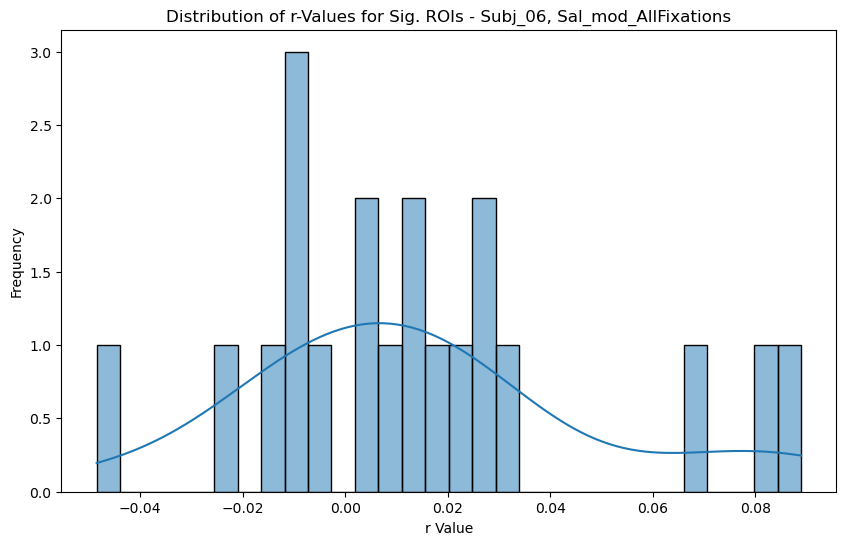

,ROI,Mean r,p-value,Significant,t_stat
28,v1,0.081210,4.998187e-243,True,46.110181
29,v2,0.088983,6.455939e-284,True,51.322805
33,v4,0.069686,4.647074e-75,True,22.782958
34,vo1,-0.013535,4.600146e-04,True,-3.565836
35,vo2,-0.008672,9.971821e-03,True,-2.601025
31,v3a,0.026045,1.585153e-21,True,10.330365
7,hmt,0.022835,6.255279e-08,True,5.681716
10,ips2,-0.008396,8.815164e-05,True,-3.986770
11,ips3,0.005931,6.565917e-03,True,2.738817
23,phc1,-0.048511,6.092603e-28,True,-14.088225


In [236]:
# Call the function to plot the distribution
plot_r_value_distribution(df_roi_stats)

In [237]:
sal_model

'AllFixations'

## Plot the ROI-specific correlation over all ROIs (with significance stars for significant ROIs)

In [ ]:
def plot_mean_correlation_with_significance(df_roi_stats):
    """
    Plot the mean correlation values for each ROI with significance stars.

    Parameters:
    - df_roi_stats: DataFrame containing ROI statistics with columns 'ROI', 'Mean r', and 'p-value'.
    """
    # Extract ROI names, mean r values, and p-values
    # rois = df_roi_stats['ROI']
    # Extract the index of the df that is were the roi names are stored

    # Handle NaN or Inf values in 'Mean r'
    df_roi_stats = df_roi_stats[~df_roi_stats['Mean r'].isnull()]  # Remove NaN
    df_roi_stats = df_roi_stats[~np.isinf(df_roi_stats['Mean r'])]  # Remove Inf


    rois = df_roi_stats['ROI']
    mean_r_values = df_roi_stats['Mean r']
    p_values = df_roi_stats['p-value']

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.bar(rois, mean_r_values, color='skyblue', edgecolor='black')

    # Adjust the y-limit to create space for significance stars
    min_r_value = min(mean_r_values)
    max_r_value = max(mean_r_values)
    plt.ylim(min_r_value - 0.05, max_r_value + 0.05)  # Add extra space above and below the bars

    # Add significance stars
    for i, (bar, p_value) in enumerate(zip(bars, p_values)):
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = ''
        
        # Add the stars above the bar
        if significance:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     significance, ha='center', va='bottom', fontsize=10, color='red')

    # Add labels and title
    plt.xlabel('ROIs', fontsize=10) 
    plt.ylabel('Mean Correlation (r)', fontsize=10)
    plt.title(f'Mean Correlation with Significance Subj_0{sub_num}, Sal_mod_{sal_model}', fontsize=14)
    plt.xticks(rotation=60, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(RESULTS_PATH_subj / f'mean_correlation_with_significance_subj0{sub_num}_{sal_model}.png', dpi=300)

    # Show the plot
    plt.show()

In [239]:
RESULTS_PATH_subj

PosixPath('/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/results/Plots_Correlation_nsd_all_shared1000/subj06')

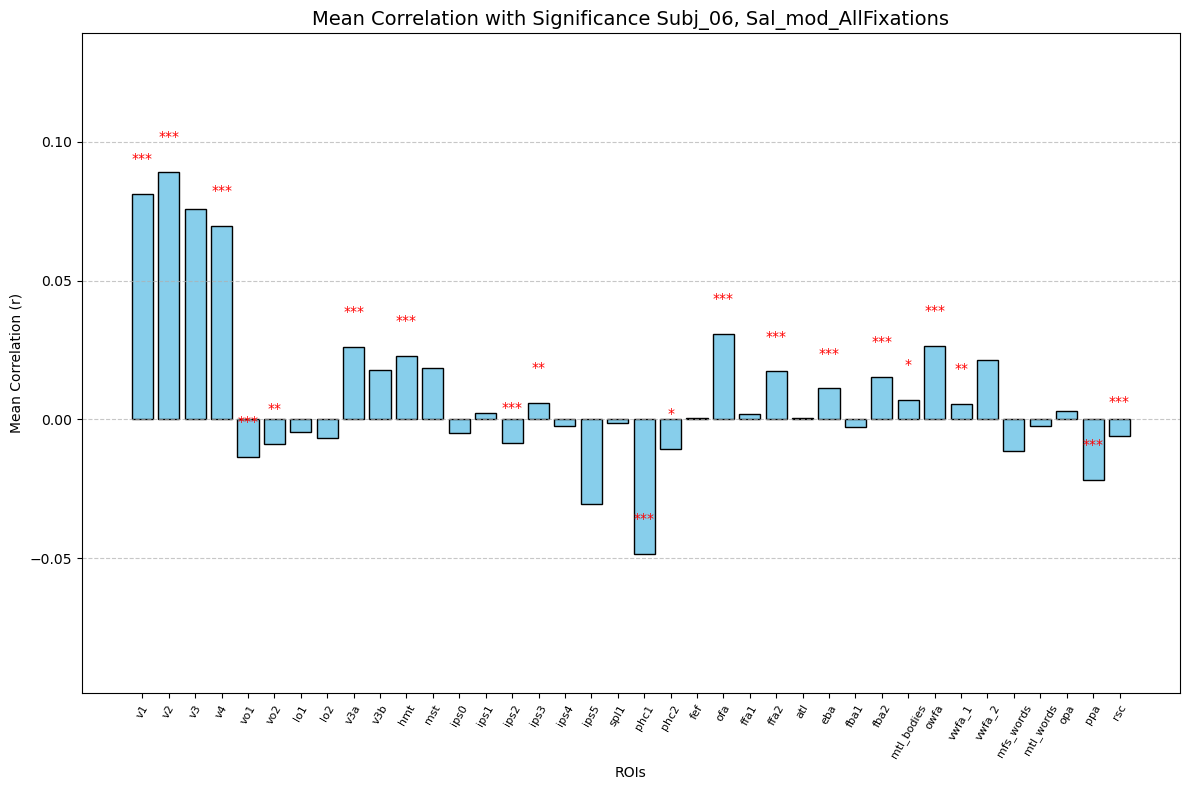

In [240]:
plot_mean_correlation_with_significance(df_roi_stats)

## Apply FDR correction to *p*-values 

In [241]:
# Apply False Discover Rate (FDR) correction for multiple comparisons 
# Use df_roi_stats DataFrame for FDR correction
def apply_fdr_correction(df_roi_stats, p_value_column='p-value', alpha=0.05):
    """
    Apply FDR correction to a DataFrame containing p-values.

    Parameters:
    - df_roi_stats: DataFrame containing p-values.
    - p_value_column: Name of the column containing p-values.
    - alpha: Significance level for FDR correction.

    Returns:
    - DataFrame with an additional column for FDR-corrected p-values and significance.
    """

    """   # Debug: Print input p-values
    print("Input p-values:")
    print(df_roi_stats[p_value_column]) """

    # Identify rows with NaN p-values
    nan_mask = df_roi_stats[p_value_column].isna()

    # Exclude NaN values and perform FDR correction on valid p-values
    valid_p_values = df_roi_stats.loc[~nan_mask, p_value_column]
    corrected_results = multipletests(valid_p_values, alpha=alpha, method='fdr_bh')

    """ # Debug: Print corrected results
    print("Corrected Results:")
    print("Significant (FDR):", corrected_results[0])
    print("FDR-corrected p-values:", corrected_results[1]) """

    # Assign corrected p-values and significance to the DataFrame
    df_roi_stats.loc[~nan_mask, 'FDR-corrected p-value'] = corrected_results[1]
    df_roi_stats.loc[~nan_mask, 'Significant (FDR)'] = corrected_results[0]

    # Assign NaN to rows with NaN p-values
    df_roi_stats.loc[nan_mask, 'FDR-corrected p-value'] = np.nan
    df_roi_stats.loc[nan_mask, 'Significant (FDR)'] = np.nan

    return df_roi_stats


In [242]:
print(df_roi_stats.columns)  # Check the column names

Index(['ROI', 'Mean r', 'p-value', 'Significant', 't_stat'], dtype='object')


In [243]:
# Function call to apply FDR correction
df_roi_stats_fdr = apply_fdr_correction(df_roi_stats, p_value_column='p-value', alpha=0.05)

# Print the updated DataFrame
print(df_roi_stats_fdr)

           ROI    Mean r        p-value  Significant     t_stat  \
28          v1  0.081210  4.998187e-243         True  46.110181   
29          v2  0.088983  6.455939e-284         True  51.322805   
30          v3  0.075885            NaN        False        NaN   
33          v4  0.069686   4.647074e-75         True  22.782958   
34         vo1 -0.013535   4.600146e-04         True  -3.565836   
35         vo2 -0.008672   9.971821e-03         True  -2.601025   
14         lo1 -0.004407            NaN        False        NaN   
15         lo2 -0.006603   5.228249e-02        False  -1.963292   
31         v3a  0.026045   1.585153e-21         True  10.330365   
32         v3b  0.017679            NaN        False        NaN   
7          hmt  0.022835   6.255279e-08         True   5.681716   
17         mst  0.018437   1.714525e-01        False   1.411604   
8         ips0 -0.004872   8.256297e-02        False  -1.740306   
9         ips1  0.002437   1.897952e-01        False   1.31413

# Applying FDR-correction 

## Plot the *r*-values for the significant rho values of df_roi_stats *(with FDR correction)*

In [ ]:
# Print r value distribution for significant ROIs

def plot_r_value_distribution(df_roi_stats_fdr):
    """
    Plot the distribution of r values for significant ROIs.

    Parameters:
    - df: DataFrame containing ROI statistics with 'Mean r' and 'Significant' columns.
    """
    # Filter the DataFrame to include only significant results
    significant_df_fdr = df_roi_stats_fdr[df_roi_stats_fdr['Significant (FDR)']== True]

    # Plot the distribution of r values for significant ROIs
    plt.figure(figsize=(10, 6))
    sns.histplot(significant_df_fdr['Mean r'], bins=30, kde=True)
    plt.title(f'Distribution of r-Values for Sig. ROIs - Subj_0{sub_num}, Sal_mod_{sal_model}')
    plt.xlabel('r Value')
    plt.ylabel('Frequency')
    # Remove grid lines
    plt.grid(False)
    plt.savefig(RESULTS_PATH_subj / f'distribution_r_values_subj0{sub_num}, Sal_mod_{sal_model}_fdr_corrected.png')
    plt.show()

    return significant_df_fdr

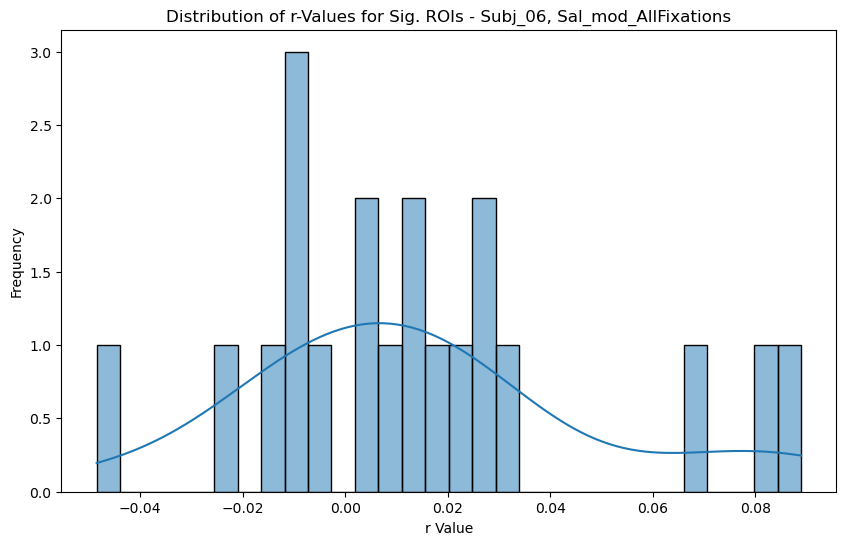

,ROI,Mean r,p-value,Significant,t_stat,FDR-corrected p-value,Significant (FDR)
28,v1,0.081210,4.998187e-243,True,46.110181,7.497280e-242,True
29,v2,0.088983,6.455939e-284,True,51.322805,1.936782e-282,True
33,v4,0.069686,4.647074e-75,True,22.782958,4.647074e-74,True
34,vo1,-0.013535,4.600146e-04,True,-3.565836,9.200292e-04,True
35,vo2,-0.008672,9.971821e-03,True,-2.601025,1.661970e-02,True
31,v3a,0.026045,1.585153e-21,True,10.330365,5.283842e-21,True
7,hmt,0.022835,6.255279e-08,True,5.681716,1.705985e-07,True
10,ips2,-0.008396,8.815164e-05,True,-3.986770,2.034269e-04,True
11,ips3,0.005931,6.565917e-03,True,2.738817,1.158691e-02,True
23,phc1,-0.048511,6.092603e-28,True,-14.088225,2.611116e-27,True


In [ ]:
# Function Call - Example 
plot_r_value_distribution(df_roi_stats_fdr)

## Plot the ROI-specific correlation over all ROIs (with significance stars for FDR -corrected significant ROIs)

Just to test how the data is distributed. 

In [ ]:
def plot_mean_correlation_with_significance_fdr(df_roi_stats_fdr):
    """
    Plot the mean correlation values for each ROI with significance stars.

    Parameters:
    - df_roi_stats_fdr: DataFrame containing ROI statistics with columns 'ROI', 'Mean r', and 'FDR-adjusted p-value'.
    """
    # Extract ROI names, mean r values, and FDR-corrected p-values

    
    # Drop rows with NaN in 'Mean r'
    df_roi_stats_fdr = df_roi_stats_fdr.dropna(subset=['Mean r'])
    
    # extract the index of the df that is were the roi names are stored
    rois = df_roi_stats_fdr['ROI']
    mean_r_values = df_roi_stats_fdr['Mean r']
    p_values = df_roi_stats_fdr['FDR-corrected p-value']
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(rois, mean_r_values, color='skyblue', edgecolor='black')

    # Adjust the y-limit to create space for significance stars
    min_r_value = min(mean_r_values)
    max_r_value = max(mean_r_values)
    plt.ylim(min_r_value - 0.05, max_r_value + 0.05)  # Add extra space above and below the bars

    # Add significance stars
    for i, (bar, p_value) in enumerate(zip(bars, p_values)):
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = ''
        
        # Add the stars above the bar
        if significance:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     significance, ha='center', va='bottom', fontsize=12, color='red')

    # Add labels and title
    plt.xlabel('ROIs', fontsize=14)
    plt.ylabel('Mean Correlation (r)', fontsize=14)
    plt.title(f'Mean Correlation with Significance Subj_0{sub_num}, Sal_mod_{sal_model}', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(RESULTS_PATH_subj / f'mean_correlation_with_significance_fdr_subj0{sub_num}_{sal_model}.png', dpi=300)

    # Show the plot
    plt.show()

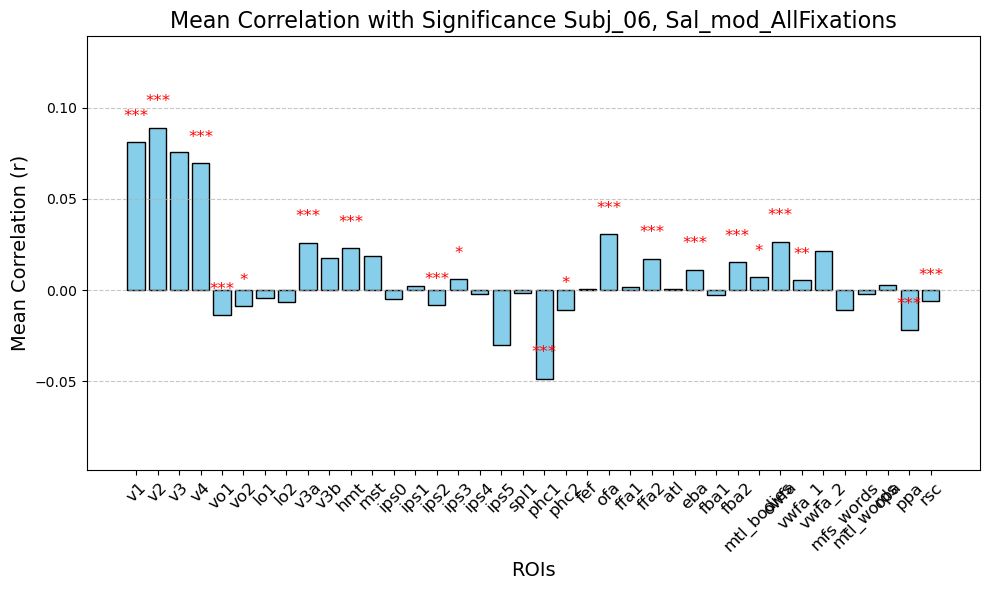

In [ ]:
plot_mean_correlation_with_significance_fdr(df_roi_stats_fdr)

# Comparison of the original p-values with the FDR-corrected p-values 

Show the differences with the applied FDR correction.

In [248]:
# Compare original p-values with FDR-adjusted p-values
df_roi_stats_comparison = df_roi_stats[['p-value', 'FDR-corrected p-value']].copy()
df_roi_stats_comparison['Difference'] = df_roi_stats_comparison['FDR-corrected p-value'] - df_roi_stats_comparison['p-value']

# Add a column to indicate the direction of change
df_roi_stats_comparison['Direction'] = np.where(
    df_roi_stats_comparison['Difference'] < 0, '-', '+'
)

# Print the comparison
print("Comparison of original p-values and FDR-adjusted p-values:")
print(df_roi_stats_comparison)

Comparison of original p-values and FDR-adjusted p-values:
          p-value  FDR-corrected p-value     Difference Direction
28  4.998187e-243          7.497280e-242  6.997461e-242         +
29  6.455939e-284          1.936782e-282  1.872222e-282         +
30            NaN                    NaN            NaN         +
33   4.647074e-75           4.647074e-74   4.182367e-74         +
34   4.600146e-04           9.200292e-04   4.600146e-04         +
35   9.971821e-03           1.661970e-02   6.647880e-03         +
14            NaN                    NaN            NaN         +
15   5.228249e-02           7.468927e-02   2.240678e-02         +
31   1.585153e-21           5.283842e-21   3.698690e-21         +
32            NaN                    NaN            NaN         +
7    6.255279e-08           1.705985e-07   1.080457e-07         +
17   1.714525e-01           2.143157e-01   4.286313e-02         +
8    8.256297e-02           1.125859e-01   3.002290e-02         +
9    1.897952e-01

In [249]:
# Count significant ROIs before and after FDR correction
num_significant_before = (df_roi_stats['p-value'] < 0.05).sum()
num_significant_after = df_roi_stats['Significant (FDR)'].sum()

print(f"Number of significant ROIs before FDR correction: {num_significant_before}")
print(f"Number of significant ROIs after FDR correction: {num_significant_after}")

Number of significant ROIs before FDR correction: 20
Number of significant ROIs after FDR correction: 20


Ok, in all cases the FDR correction slightly increased the *p*-values, however it did not effect the significance level. 

In [250]:
# Save the updated DataFrame with FDR correction results
df_roi_stats_fdr.to_csv(RESULTS_PATH_subj / f'roi_means_subj0{sub_num}_{sal_model}_fdr_corrected.csv', index=False)

In [251]:
RESULTS_PATH_subj

PosixPath('/gpfs01/bartels/group/lheinemann/saliency-nsd-pub/results/Plots_Correlation_nsd_all_shared1000/subj06')

In [ ]:
# Load one simple dataframe to test 

#pd.read_csv(RESULTS_PATH_subj / f'roi_means_subj0{sub_num}_{sal_model}_fdr_corrected.csv', index_col=0).reset_index()